In [1]:
import datetime
import calendar
import warnings

import numpy as np
import pandas as pd

import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

pd.set_option('display.max_rows', 15)
pd.options.display.float_format = "{:,.2f}".format

import seaborn as sns
cm = sns.light_palette("red", as_cmap=True)
import datetime
import plotly.graph_objects as go

In [2]:
open_list = pd.read_csv('data/open_item_list.csv')
payment_list = pd.read_csv('data/payment_list_of_customers.csv')

## Open List

In [3]:
# Format open_list, edit columns name
open_list = open_list.rename(columns={'Cutomer number': 'customer_number',
                                     'Customer name': 'customer_name',
                                     'Country':'country',
                                      'Invoice number':'invoice_number',
                                      'Invoice date':'invoice_date',
                                      'Invoice amount \n(incl. VAT if applicable)':'invoice_inc_vat',
                                      'Open amount\n(incl. VAT if applicable)':'open_inc_vat',
                                      'Due date': 'due_date',
                                      'Days overdue \nby 2021-10-31':'days_overdue_by_oct31',
                                     }).reset_index()

# open_list = open_list.reset_index()

In [4]:
# Create id column in open_list
open_list['id'] = open_list['customer_number'] + '-' + open_list['customer_name'] + open_list['country']
open_list = open_list.drop(open_list.index[0])
open_list = open_list.fillna(0)

# Create additional columns
open_list['invoice_exc_vat'] = np.where(open_list["country"] == 'DE', open_list["invoice_inc_vat"]/1.19, open_list["invoice_inc_vat"])
open_list['open_exc_vat'] = np.where(open_list["country"] == 'DE', open_list["open_inc_vat"]/1.19, open_list["open_inc_vat"])
open_list[['invoice_date','due_date']] = open_list[['invoice_date','due_date']].apply(pd.to_datetime, format='%Y-%m-%d')

In [5]:
# test_open = open_list.copy()
open_list.drop(columns='level_0',inplace=True)
close_day = pd.to_datetime('31-10-2021')
open_list['invoice_date'] = open_list['invoice_date'].apply(pd.to_datetime, format='%Y-%m-%d')
open_list['due_date'] = open_list['due_date'].apply(pd.to_datetime, format='%Y-%m-%d')
open_list['days_after_invoice'] = (close_day - open_list['invoice_date']).dt.days
open_list['overdue_days'] = (close_day - open_list['due_date']).dt.days
open_list['contract_days'] = (open_list['due_date'] - open_list['invoice_date']).dt.days
open_list['customer_number'] = open_list['customer_number'].astype(np.integer)
open_list[open_list['customer_number'] == 1071535]

,index,customer_number,customer_name,country,invoice_number,invoice_date,invoice_inc_vat,open_inc_vat,due_date,days_overdue_by_oct31,id,invoice_exc_vat,open_exc_vat,days_after_invoice,overdue_days,contract_days
1,0,1071535,AB Ltd.,FR,"10,142.00",2021-04-30,"5,221.13","5,221.13",2021-05-30,154.00,1071535-AB Ltd.FR,"5,221.13","5,221.13",184,154,30
2,1,1071535,AB Ltd.,FR,"10,146.00",2021-04-30,"12,771.68","12,771.68",2021-05-30,154.00,1071535-AB Ltd.FR,"12,771.68","12,771.68",184,154,30
3,2,1071535,AB Ltd.,FR,"10,180.00",2021-06-30,"17,028.90","17,028.90",2021-08-14,78.00,1071535-AB Ltd.FR,"17,028.90","17,028.90",123,78,45
4,3,1071535,AB Ltd.,FR,"10,007.00",2021-09-08,"7,470.23","7,470.23",2021-10-08,23.00,1071535-AB Ltd.FR,"7,470.23","7,470.23",53,23,30
5,4,1071535,AB Ltd.,FR,"10,014.00",2021-09-30,"3,775.28","3,775.28",2021-11-09,-9.00,1071535-AB Ltd.FR,"3,775.28","3,775.28",31,-9,40
6,5,1071535,AB Ltd.,FR,"202,110.00",2021-10-19,"40,242.84","40,242.84",2021-10-19,12.00,1071535-AB Ltd.FR,"40,242.84","40,242.84",12,12,0


In [6]:
# create due days columns for open_list
open_list['not_due'] = open_list[['open_exc_vat']].sum(axis=1).where(open_list['overdue_days'] <= 0, 0)
open_list['overdue_10d'] = open_list[['open_exc_vat']].sum(axis=1).where((open_list['overdue_days'] > 0) & (open_list['overdue_days'] <= 10), 0)
open_list['overdue_11_30d'] = open_list[['open_exc_vat']].sum(axis=1).where((open_list['overdue_days'] > 10) & (open_list['overdue_days'] <= 30), 0)
open_list['overdue_31_60d'] = open_list[['open_exc_vat']].sum(axis=1).where((open_list['overdue_days'] > 30) & (open_list['overdue_days'] <= 60), 0)
open_list['overdue_61_90d'] = open_list[['open_exc_vat']].sum(axis=1).where((open_list['overdue_days'] > 60) & (open_list['overdue_days'] <= 90), 0)
open_list['overdue_90+d'] = open_list[['open_exc_vat']].sum(axis=1).where(open_list['overdue_days'] > 90, 0)

open_list

,index,customer_number,customer_name,country,invoice_number,invoice_date,invoice_inc_vat,open_inc_vat,due_date,days_overdue_by_oct31,...,open_exc_vat,days_after_invoice,overdue_days,contract_days,not_due,overdue_10d,overdue_11_30d,overdue_31_60d,overdue_61_90d,overdue_90+d
1,0,1071535,AB Ltd.,FR,"10,142.00",2021-04-30,"5,221.13","5,221.13",2021-05-30,154.00,...,"5,221.13",184,154,30,0.00,0.00,0.00,0.00,0.00,"5,221.13"
2,1,1071535,AB Ltd.,FR,"10,146.00",2021-04-30,"12,771.68","12,771.68",2021-05-30,154.00,...,"12,771.68",184,154,30,0.00,0.00,0.00,0.00,0.00,"12,771.68"
3,2,1071535,AB Ltd.,FR,"10,180.00",2021-06-30,"17,028.90","17,028.90",2021-08-14,78.00,...,"17,028.90",123,78,45,0.00,0.00,0.00,0.00,"17,028.90",0.00
4,3,1071535,AB Ltd.,FR,"10,007.00",2021-09-08,"7,470.23","7,470.23",2021-10-08,23.00,...,"7,470.23",53,23,30,0.00,0.00,"7,470.23",0.00,0.00,0.00
5,4,1071535,AB Ltd.,FR,"10,014.00",2021-09-30,"3,775.28","3,775.28",2021-11-09,-9.00,...,"3,775.28",31,-9,40,"3,775.28",0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,92,1066009,ZA SE,DE,"20,577.00",2021-06-30,"13,291.28","13,291.28",2021-08-29,63.00,...,"11,169.14",123,63,60,0.00,0.00,0.00,0.00,"11,169.14",0.00
94,93,1066009,ZA SE,DE,"20,578.00",2021-06-30,"177,310.00","177,310.00",2021-08-29,63.00,...,"149,000.00",123,63,60,0.00,0.00,0.00,0.00,"149,000.00",0.00
95,94,1066009,ZA SE,DE,"20,000.00",2021-07-20,"6,220.50","6,220.50",2021-09-18,43.00,...,"5,227.31",103,43,60,0.00,0.00,0.00,"5,227.31",0.00,0.00
96,95,1066009,ZA SE,DE,"20,001.00",2021-07-22,"59,046.31","59,046.31",2021-09-20,41.00,...,"49,618.75",101,41,60,0.00,0.00,0.00,"49,618.75",0.00,0.00


In [7]:
# create a list of our conditions
open_conditions = [
    (open_list['days_after_invoice'] <= 10),
    (open_list['days_after_invoice'] > 10) & (open_list['days_after_invoice'] <= 30),
    (open_list['days_after_invoice'] > 30) & (open_list['days_after_invoice'] <= 60),
    (open_list['days_after_invoice'] > 60) & (open_list['days_after_invoice'] <= 90),
    (open_list['days_after_invoice'] > 90)
    ]

# create a list of the values we want to assign for each condition
values = [1,2,3,4,5]

# create the tier base of value
open_list['score_apply'] = np.select(open_conditions, values)
open_list['weighted_open_exc_vat'] = open_list['open_exc_vat']*open_list['score_apply']
# open_list

In [8]:
# Summary open_list by customer
open_list_customer = open_list.groupby(['id','customer_number', 'customer_name', 'country'])[['invoice_inc_vat', 'open_inc_vat','invoice_exc_vat',
       'open_exc_vat','weighted_open_exc_vat','not_due', 'overdue_10d', 'overdue_11_30d', 'overdue_31_60d',
       'overdue_61_90d', 'overdue_90+d']].sum().reset_index()

# Calculate open EPS for customer
open_list_customer['open_EPS'] = open_list_customer['weighted_open_exc_vat']/open_list_customer['open_exc_vat']

## Payment List

In [9]:
# Format payment_list 
# Edit columns name
payment_list = payment_list.rename(columns={'Customer  No.': 'customer_number',
                                     'Country':'country',
                                     'Customer':'customer_name',
                                      'Revenues (net w/o VAT)':'revenue_net_wo_vat',
                                      'Discount (0,05%)':'discount_0.05',
                                      'Paid within 10 Days':'paid_in_10d',
                                      'Paid 11-30 Days':'paid_11_30d',
                                      'Paid 31-60Days':'paid_31_60d',
                                      'Paid 61-90 Days': 'paid_61_90d',
                                      'Paid 90+ Days': 'paid_90+d',
                                      'Total amount':'total_payment',
                                     })

# Create id column in payment_list
payment_list['id'] = payment_list['customer_number'].astype('str') + '-' + payment_list['customer_name'] + payment_list['country']   

# Fillna in payment_list
payment_list = payment_list.fillna(0)           

In [10]:
# Summarize payment_list by customers
payment_list_customer = payment_list.groupby(['id', 'customer_number', 'country', 'customer_name'])[['discount_0.05','paid_in_10d', 'paid_11_30d',
       'paid_31_60d', 'paid_61_90d', 'paid_90+d', 'total_payment']].sum().reset_index()


In [11]:
# Calculate EPS in payment_list
weighted_list = [1,2,3,4,5]

# test_payment_list = payment_list.copy()

for i in weighted_list:
    payment_list_customer['sum_weighted'] = payment_list_customer['paid_in_10d']*weighted_list[0] + payment_list_customer['paid_11_30d']*weighted_list[1] + payment_list_customer['paid_31_60d']*weighted_list[2] + payment_list_customer['paid_61_90d']*weighted_list[3] + payment_list_customer['paid_90+d']*weighted_list[4]

payment_list_customer['payment_EPS'] = payment_list_customer['sum_weighted'] / payment_list_customer['total_payment']



In [12]:
# Create EPS tier by customer
tier_conditions = [
    (payment_list_customer['payment_EPS'] <= 1.7),
    (payment_list_customer['payment_EPS'] > 1.7) & (payment_list_customer['payment_EPS'] <= 2.7),
    (payment_list_customer['payment_EPS'] > 2.7 ) & (payment_list_customer['payment_EPS'] <= 3.7),
    (payment_list_customer['payment_EPS'] > 3.7)
    ]

tiers = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4']

payment_list_customer['payment_EPS_tier'] = np.select(tier_conditions, tiers)


## Merge data between Payment list and Open list

In [13]:
# Merge open_list and payment_list
merge_data = payment_list_customer.merge(open_list_customer, on ='id', how='outer',suffixes=('_pm', '_op'))

merge_data = merge_data.fillna(0)

merge_data['total'] = merge_data['total_payment'] + merge_data['open_exc_vat']


In [14]:
# Create calculation columns in merge data
merge_data['base_amount'] = merge_data['total_payment']+merge_data['open_exc_vat']
merge_data['wtd_payment'] = (merge_data['total_payment']*merge_data['payment_EPS']) 
merge_data['wtd_open'] = (merge_data['open_exc_vat']+merge_data['open_EPS'])


In [15]:
# Calculate total EPS
merge_data['EPS'] = ((merge_data['total_payment']*merge_data['payment_EPS']) + (merge_data['open_exc_vat']*merge_data['open_EPS']))/(merge_data['total_payment']+merge_data['open_exc_vat'])


In [16]:
# Create EPS tier by customer
tier_conditions = [
    (merge_data['EPS'] <= 1.7),
    (merge_data['EPS'] > 1.7) & (merge_data['EPS'] <= 2.7),
    (merge_data['EPS'] > 2.7 ) & (merge_data['EPS'] <= 3.7),
    (merge_data['EPS'] > 3.7)
    ]

tiers = ['Tier 1', 'Tier 2', 'Tier 3', 'Tier 4']

merge_data['EPS_tier'] = np.select(tier_conditions, tiers)

In [17]:
# Create tier by customer value
value_conditions = [
    (merge_data['total'] >= 100000),
    (merge_data['total'] < 100000) & (merge_data['total'] >= 50000),
    (merge_data['total'] < 50000 ) & (merge_data['total'] >= 25000),
    (merge_data['total'] < 25000)
    ]

values = ['01. >100k', '02. >50K', '03. >25K', '04. <25K']

merge_data['value_tier'] = np.select(value_conditions, values)


In [23]:
# Calculate total due by customer
merge_data['total_due'] = merge_data['overdue_10d'] + merge_data['overdue_11_30d'] + merge_data['overdue_31_60d'] + merge_data['overdue_61_90d'] + merge_data['overdue_90+d']

## Waterfall chart & Matrix

In [24]:
# Prepare data for waterfall chart
operating_sales_rev = merge_data['discount_0.05'].sum().round(0)+merge_data['total'].sum().round(0)
net_sale = merge_data['total'].sum().round(0)
discount = merge_data['discount_0.05'].sum().round(0)
paid = merge_data['total_payment'].sum().round(0)
open_invoices = merge_data['open_exc_vat'].sum().round(0)
not_due = merge_data['not_due'].sum().round(0)
total_due = (merge_data['overdue_10d'].sum() + merge_data['overdue_11_30d'].sum() + merge_data['overdue_31_60d'].sum() + merge_data['overdue_61_90d'].sum() + merge_data['overdue_90+d'].sum()).round(0)
overdue_1_10d = merge_data['overdue_10d'].sum().round(0)
overdue_11_30d = merge_data['overdue_11_30d'].sum().round(0)
overdue_31_60d = merge_data['overdue_31_60d'].sum().round(0)
overdue_61_90d = merge_data['overdue_61_90d'].sum().round(0)
overdue_more_91d = merge_data['overdue_90+d'].sum().round(0)

# Create list from calculated data
wf_list = ['operating_sales_rev','net_sale','discount','paid','open_invoices','not_due','total_due','overdue_1_10d','overdue_11_30d','overdue_31_60d','overdue_61_90d','overdue_more_91d']
wf_data = [operating_sales_rev,net_sale,discount,paid,open_invoices,not_due,total_due,overdue_1_10d,overdue_11_30d,overdue_31_60d,overdue_61_90d,overdue_more_91d]


In [19]:
# create waterfall chart

fig = go.Figure(go.Waterfall(
    x = ['Net Sales','Discount','Operating Sales/Revenue','Paid Invoices','Account Receivables','Not Due','Overdue'
            ,'1-10 days overdue','11-30 days overdue','31-60 days overdue','61-90 days overdue','+90 days overdue'],
    measure = ["absolute", "relative", "absolute", "relative", "absolute", "relative", "absolute", "relative", "relative","relative","relative","relative"],
    y = [operating_sales_rev,-discount,net_sale,-paid,open_invoices,-not_due,total_due,-overdue_1_10d,-overdue_11_30d,-overdue_31_60d,-overdue_61_90d,-overdue_more_91d], base = 0,
    text = ["€3,532","€4" , "€3,528", "€1,695", "€1,834", "€825","€1,009","€333","€89","€104","€228","€256"],
    decreasing = {"marker":{"color":"orange", "line":{"color":"red", "width":2}}},
    textposition = "outside",
    increasing = {"marker":{"color":"Teal"}},
    totals = {"marker":{"color":"deep sky blue", "line":{"color":"blue", "width":3}}},
    # bgclor = None
))

fig.update_layout(title = "Big Picture", waterfallgap = 0.3)
fig.update_yaxes(range=[-500000, 4000000])
fig.update_yaxes(title_text='EUR, in millions')
fig.update_xaxes(tickangle=-45)
# plot_url = py.plot(fig, filename='transparent-background')
fig.show()



In [20]:
# Calculate matrix for customer EPS tier and value tier
matrix = pd.pivot_table(merge_data, values='total', index='EPS_tier', columns='value_tier', aggfunc='sum',margins=True,margins_name='Grand Total')

matrix = matrix.fillna(0)
pd.options.display.float_format = '{:,.0f}'.format
# matrix = matrix.style.background_gradient(cmap='coolwarm')

matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,"336,975","86,557",0,"9,417","432,949"
Tier 2,"996,927",0,0,"31,416","1,028,343"
Tier 3,"493,634","357,757","153,725","145,837","1,150,953"
Tier 4,"818,700",0,"32,370","65,110","916,180"
Grand Total,"2,646,236","444,314","186,095","251,779","3,528,425"


In [57]:
# Customer net sale and bracket
payment_list_mapping = payment_list_customer.merge(merge_data, on='id')
payment_list_mapping['total_c'] = payment_list_mapping['total']
payment_list_mapping_check = pd.pivot_table(payment_list_mapping, index=['value_tier'],
                     aggfunc={'id' : 'count', 'total' : 'sum', 'total_c': lambda x: x.sum() / payment_list_mapping['total'].sum()}).reset_index()

payment_list_mapping_check.rename(columns={'id':'number of customer','total':'total payment', 'total_c': '% of total payment'}, inplace=True)
pd.options.display.float_format = '{:,.2f}'.format
payment_list_mapping_check

,value_tier,number of customer,total payment,% of total payment
0,01. >100k,10,"2,646,236.41",0.75
1,02. >50K,7,"444,314.02",0.13
2,03. >25K,5,"186,095.38",0.05
3,04. <25K,23,"251,561.74",0.07


In [27]:
# Drop unnecessary columns
merge_data = merge_data.drop(columns=['customer_number_op', 'customer_name_op', 'country_op', 'wtd_open'])

In [28]:
# Block 2.a
matrix = pd.pivot_table(merge_data, values='total', index='EPS_tier', columns='value_tier', aggfunc='count',margins=True,margins_name='Grand Total')

matrix = matrix.fillna(0)
matrix = matrix.astype(int)
matrix = matrix.style.background_gradient(low=0.35, high=1.0)
# matrix = matrix.style.background_gradient(cmap='coolwarm')

matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,2,1,0,3,6
Tier 2,4,0,0,5,9
Tier 3,2,6,4,11,23
Tier 4,2,0,1,5,8
Grand Total,10,7,5,24,46


In [29]:
# Block 2.a
matrix_count = pd.pivot_table(merge_data, values='total', index='EPS_tier', columns='value_tier', aggfunc = lambda x: x.count() / merge_data['total'].count(),margins=True,margins_name='Grand Total') 

matrix_count = matrix_count.fillna(0)

cm = sns.light_palette("red", as_cmap=True)
pd.options.display.float_format = '{:,.1%}'.format
# matrix_count.style.background_gradient(cmap='coolwarm')
matrix_count


value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,4.3%,2.2%,0.0%,6.5%,13.0%
Tier 2,8.7%,0.0%,0.0%,10.9%,19.6%
Tier 3,4.3%,13.0%,8.7%,23.9%,50.0%
Tier 4,4.3%,0.0%,2.2%,10.9%,17.4%
Grand Total,21.7%,15.2%,10.9%,52.2%,100.0%


In [30]:
merge_data.rename(columns={'customer_number_pm':'customer_number',
                            'country_pm': 'country', 'customer_name_pm':'customer_name'},inplace=True)

In [31]:
merge_data.columns

Index(['id', 'customer_number', 'country', 'customer_name', 'discount_0.05',
       'paid_in_10d', 'paid_11_30d', 'paid_31_60d', 'paid_61_90d', 'paid_90+d',
       'total_payment', 'sum_weighted', 'payment_EPS', 'payment_EPS_tier',
       'invoice_inc_vat', 'open_inc_vat', 'invoice_exc_vat', 'open_exc_vat',
       'weighted_open_exc_vat', 'not_due', 'overdue_10d', 'overdue_11_30d',
       'overdue_31_60d', 'overdue_61_90d', 'overdue_90+d', 'open_EPS', 'total',
       'base_amount', 'wtd_payment', 'EPS', 'EPS_tier', 'value_tier',
       'total_due'],
      dtype='object')

In [32]:
# Block 2.b - Paid Revenue
matrix = pd.pivot_table(merge_data, values='total_payment', index='EPS_tier', columns='value_tier', aggfunc='sum',margins=True,margins_name='Grand Total')

matrix = matrix.fillna(0)
matrix = matrix.astype(int)
pd.options.display.float_format = '{:,.0f}'.format
matrix = matrix.style.background_gradient(low=0.35, high=1.0)

matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,335988,84558,0,7688,428234
Tier 2,775354,0,0,26081,801436
Tier 3,253117,14873,53565,23749,345306
Tier 4,99778,0,8570,11383,119731
Grand Total,1464238,99432,62135,68902,1694708


In [33]:
# Block 2.b - Open Revenue
matrix = pd.pivot_table(merge_data, values='open_exc_vat', index='EPS_tier', columns='value_tier', aggfunc='sum',margins=True,margins_name='Grand Total')

matrix = matrix.fillna(0)
matrix = matrix.astype(int)
# pd.options.display.float_format = '{:,.0f}'.format
matrix = matrix.style.background_gradient(low=0.35, high=1.0)

matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,987,1998,0,1728,4714
Tier 2,221572,0,0,5334,226906
Tier 3,240516,342883,100159,122087,805646
Tier 4,718921,0,23800,53726,796448
Grand Total,1181997,344881,123959,182876,1833716


In [34]:
# Block 2.b - Open Revenue
matrix = pd.pivot_table(merge_data, values='total', index='EPS_tier', columns='value_tier', aggfunc='sum',margins=True,margins_name='Grand Total')

matrix = matrix.fillna(0)
matrix = matrix.astype(int)
# pd.options.display.float_format = '{:,.0f}'.format
matrix = matrix.style.background_gradient(low=0.35, high=1.0)

matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,336975,86556,0,9416,432948
Tier 2,996927,0,0,31415,1028342
Tier 3,493633,357757,153725,145836,1150953
Tier 4,818700,0,32370,65109,916180
Grand Total,2646236,444314,186095,251779,3528424


In [35]:
# Block 2.b - Total discount
matrix = pd.pivot_table(merge_data, values='discount_0.05', index='EPS_tier', columns='value_tier', aggfunc='sum',margins=True,margins_name='Grand Total')

matrix = matrix.fillna(0)
pd.options.display.float_format = '{:,.0f}'.format
matrix = matrix.astype(int)
matrix = matrix.style.background_gradient(low=0.35, high=1.0)

matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,1046,254,0,38,1340
Tier 2,1863,0,0,0,1863
Tier 3,285,74,38,0,398
Tier 4,0,0,43,0,43
Grand Total,3195,329,81,38,3645


In [37]:
# open_list.to_csv('open_list.csv')
contract_day = open_list[['id', 'customer_number', 'customer_name', 'country','contract_days']]
merge_data_contract_day = merge_data[['id', 'customer_number', 'country', 'customer_name','EPS', 'EPS_tier','value_tier']]
contract_day_total = contract_day.merge(merge_data_contract_day,on='id')


In [38]:
# Block 2.c​ - Avg. Contract Days​
contract_day_matrix = pd.pivot_table(contract_day_total, values='contract_days', index='EPS_tier', columns='value_tier', aggfunc='mean',margins=True,margins_name='Grand Total')

contract_day_matrix = contract_day_matrix.fillna(0)
# pd.options.display.float_format = '{:,.0f}'.format
# contract_day_matrix = contract_day_matrix.style.background_gradient(cmap='coolwarm')

contract_day_matrix = contract_day_matrix.astype(int)
contract_day_matrix = contract_day_matrix.style.background_gradient(low=0.35, high=1.0)

contract_day_matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,14,30,0,45,35
Tier 2,36,0,0,60,38
Tier 3,60,60,50,60,58
Tier 4,60,0,0,54,54
Grand Total,51,58,45,57,54


In [39]:
# Block 2.c​ - Avg. Contract Days​
contract_day_matrix = pd.pivot_table(contract_day_total, values='contract_days', index='EPS_tier', columns='value_tier', aggfunc='max',margins=True,margins_name='Grand Total')

contract_day_matrix = contract_day_matrix.fillna(0)
pd.options.display.float_format = '{:,.1f}'.format
# matrix = matrix.style.background_gradient(cmap='coolwarm')

contract_day_matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,14.0,30.0,0.0,60.0,60
Tier 2,60.0,0.0,0.0,60.0,60
Tier 3,60.0,60.0,60.0,70.0,70
Tier 4,60.0,0.0,0.0,60.0,60
Grand Total,60.0,60.0,60.0,70.0,70


In [40]:
# Block 2.c​ - Avg. Contract Days​
contract_day_matrix = pd.pivot_table(contract_day_total, values='contract_days', index='EPS_tier', columns='value_tier', aggfunc='min',margins=True,margins_name='Grand Total')

contract_day_matrix = contract_day_matrix.fillna(0)
pd.options.display.float_format = '{:,.1f}'.format
# matrix = matrix.style.background_gradient(cmap='coolwarm')

contract_day_matrix

value_tier,01. >100k,02. >50K,03. >25K,04. <25K,Grand Total
EPS_tier,,,,,
Tier 1,14.0,30.0,0.0,30.0,14
Tier 2,0.0,0.0,0.0,60.0,0
Tier 3,60.0,60.0,10.0,60.0,10
Tier 4,60.0,0.0,0.0,30.0,0
Grand Total,0.0,30.0,0.0,30.0,0


In [41]:
# 5 Biggest overdue customer
top_due = merge_data.groupby(['country','customer_name'])['total_due'].sum().reset_index(name='total_due_amount')
top_due.sort_values(by='total_due_amount', ascending=False)[:5]

,country,customer_name,total_due_amount
14,DE,EE Deutschland GmbH,"323,607.0"
29,DE,ZA SE,"242,515.2"
30,FR,AB Ltd.,"82,734.8"
12,DE,E SE,"69,498.9"
39,SZ,PC Ltd.,"63,899.3"


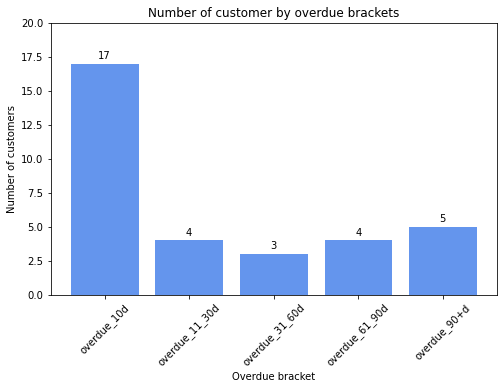

In [42]:
merge_data_copy = merge_data.copy()

# create a list of our conditions
bracket_open_conditions = [
    (merge_data_copy['overdue_10d'] > 0),
    (merge_data_copy['overdue_11_30d'] > 0),
    (merge_data_copy['overdue_31_60d'] > 0),
    (merge_data_copy['overdue_61_90d'] > 0),
    (merge_data_copy['overdue_90+d'] > 0),
    ]

# create a list of the values we want to assign for each condition
bracket_values = ['overdue_10d','overdue_11_30d','overdue_31_60d','overdue_61_90d','overdue_90+d']

merge_data_copy['over_due_bracket'] = np.select(bracket_open_conditions, bracket_values)
# open_list['weighted_open_exc_vat'] = open_list['open_exc_vat']*open_list['score_apply']

nb_overdue_10d = merge_data_copy[merge_data_copy['overdue_10d'] > 0]['id'].count()
nb_overdue_11_30d = merge_data_copy[merge_data_copy['overdue_11_30d'] > 0]['id'].count()
nb_overdue_31_60d = merge_data_copy[merge_data_copy['overdue_31_60d'] > 0]['id'].count()
nb_overdue_61_90d = merge_data_copy[merge_data_copy['overdue_61_90d'] > 0]['id'].count()
nb_overdue_91d = merge_data_copy[merge_data_copy['overdue_90+d'] > 0]['id'].count()

nb_overdue_bracket_df = {'overdue_10d':nb_overdue_10d,'overdue_11_30d':nb_overdue_11_30d,'overdue_31_60d':nb_overdue_31_60d,'overdue_61_90d':nb_overdue_61_90d,'overdue_90+d':nb_overdue_91d}
nb_overdue_bracket_df = pd.DataFrame(nb_overdue_bracket_df, index = range(1)).T

# overdue_bracket_df_tranpose = overdue_bracket_df.T

nb_overdue_bracket_df = nb_overdue_bracket_df.reset_index()
nb_overdue_bracket_df.rename(columns={'index':'bracket',0:'nb_customer'},inplace=True)

# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(nb_overdue_bracket_df['bracket'],nb_overdue_bracket_df['nb_customer'],color='cornflowerblue')
plt.xticks(rotation=45)
plt.ylim(0,20)

# Plot the figure.
plt.title('Number of customer by overdue brackets')
plt.xlabel('Overdue bracket')
plt.ylabel('Number of customers')

for x,y in zip(nb_overdue_bracket_df['bracket'],nb_overdue_bracket_df['nb_customer']):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

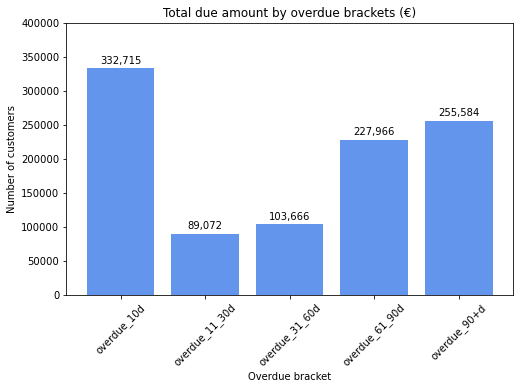

In [43]:
amount_overdue_10d = merge_data_copy[merge_data_copy['overdue_10d'] > 0]['overdue_10d'].sum()
amount_overdue_11_30d = merge_data_copy[merge_data_copy['overdue_11_30d'] > 0]['overdue_11_30d'].sum()
amount_overdue_31_60d = merge_data_copy[merge_data_copy['overdue_31_60d'] > 0]['overdue_31_60d'].sum()
amount_overdue_61_90d = merge_data_copy[merge_data_copy['overdue_61_90d'] > 0]['overdue_61_90d'].sum()
amount_overdue_91d = merge_data_copy[merge_data_copy['overdue_90+d'] > 0]['overdue_90+d'].sum()

amount_overdue_bracket_df = {'overdue_10d':amount_overdue_10d,'overdue_11_30d':amount_overdue_11_30d,'overdue_31_60d':amount_overdue_31_60d,'overdue_61_90d':amount_overdue_61_90d,'overdue_90+d':amount_overdue_91d}
amount_overdue_bracket_df = pd.DataFrame(amount_overdue_bracket_df, index = range(1)).T
amount_overdue_bracket_df = amount_overdue_bracket_df.reset_index()
amount_overdue_bracket_df.rename(columns={'index':'bracket',0:'total_amount'},inplace=True)

# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(amount_overdue_bracket_df['bracket'],amount_overdue_bracket_df['total_amount'],color='cornflowerblue')
plt.xticks(rotation=45)
plt.ylim(0,400000)

# Plot the figure.
plt.title('Total due amount by overdue brackets (€)')
plt.xlabel('Overdue bracket')
plt.ylabel('Number of customers')

for x,y in zip(amount_overdue_bracket_df['bracket'],amount_overdue_bracket_df['total_amount']):

    label = "{:,.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

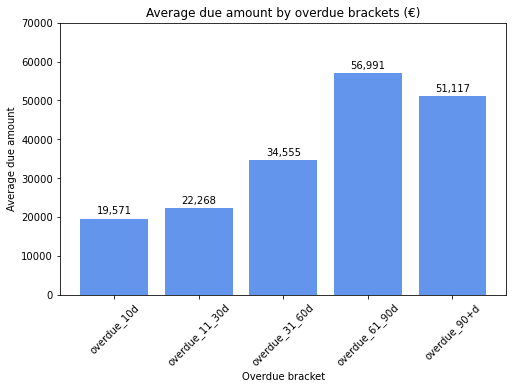

In [44]:
avg_overdue_10d =  amount_overdue_10d/nb_overdue_10d
avg_overdue_11_30d = amount_overdue_11_30d/nb_overdue_11_30d
avg_overdue_31_60d = amount_overdue_31_60d/nb_overdue_31_60d
avg_overdue_61_90d = amount_overdue_61_90d/nb_overdue_61_90d
avg_overdue_91d = amount_overdue_91d/nb_overdue_91d

avg_overdue_bracket_df = {'overdue_10d':avg_overdue_10d,'overdue_11_30d':avg_overdue_11_30d,'overdue_31_60d':avg_overdue_31_60d,'overdue_61_90d':avg_overdue_61_90d,'overdue_90+d':avg_overdue_91d}
avg_overdue_bracket_df = pd.DataFrame(avg_overdue_bracket_df, index = range(1)).T
avg_overdue_bracket_df = avg_overdue_bracket_df.reset_index()
avg_overdue_bracket_df.rename(columns={'index':'bracket',0:'avg_amount'},inplace=True)

# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(avg_overdue_bracket_df['bracket'],avg_overdue_bracket_df['avg_amount'],color='cornflowerblue')
plt.xticks(rotation=45)
plt.ylim(0,70000)

# Plot the figure.
plt.title('Average due amount by overdue brackets (€)')
plt.xlabel('Overdue bracket')
plt.ylabel('Average due amount')

for x,y in zip(avg_overdue_bracket_df['bracket'],avg_overdue_bracket_df['avg_amount']):

    label = "{:,.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

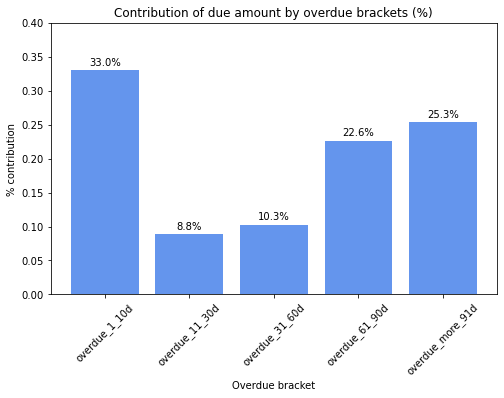

In [45]:
total_due = (merge_data['overdue_10d'].sum() + merge_data['overdue_11_30d'].sum() + merge_data['overdue_31_60d'].sum() + merge_data['overdue_61_90d'].sum() + merge_data['overdue_90+d'].sum()).round(0)
overdue_1_10d = merge_data['overdue_10d'].sum().round(0)
overdue_11_30d = merge_data['overdue_11_30d'].sum().round(0)
overdue_31_60d = merge_data['overdue_31_60d'].sum().round(0)
overdue_61_90d = merge_data['overdue_61_90d'].sum().round(0)
overdue_more_91d = merge_data['overdue_90+d'].sum().round(0)

total_overdue_bracket_df = {'overdue_1_10d':overdue_1_10d,'overdue_11_30d':overdue_11_30d,'overdue_31_60d':overdue_31_60d,'overdue_61_90d':overdue_61_90d,'overdue_more_91d':overdue_more_91d}
total_overdue_bracket_df = pd.DataFrame(total_overdue_bracket_df, index = range(1)).T
total_overdue_bracket_df = total_overdue_bracket_df.reset_index()
total_overdue_bracket_df.rename(columns={'index':'bracket',0:'avg_amount'},inplace=True)
total_overdue_bracket_df['pct_ctr'] = total_overdue_bracket_df['avg_amount']/total_overdue_bracket_df['avg_amount'].sum()

pd.options.display.float_format = '{:,.2%}'.format

# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(total_overdue_bracket_df['bracket'],total_overdue_bracket_df['pct_ctr'],color='cornflowerblue')
plt.xticks(rotation=45)
plt.ylim(0,0.4)

# Plot the figure.
plt.title('Contribution of due amount by overdue brackets (%)')
plt.xlabel('Overdue bracket')
plt.ylabel('% contribution')

for x,y in zip(total_overdue_bracket_df['bracket'],total_overdue_bracket_df['pct_ctr']):

    label = "{:,.1%}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()

## Strategy comparison

In [46]:
# Strategy comparison
data = {'Metric':['net_sales','discount','costs','margin','margin_pct'],'Current Scenario': [3528425,3646,2456000,1072425,0.3039], 
        'Smart Loyalty Discount Policy': [3513211,18860,2456000,1057211,0.3009], 'delta':[-15214,15214,0,-1521437,-0.003]}  
pd.options.display.float_format = '{:,.0f}'.format

data = pd.DataFrame(data)

data

,Metric,Current Scenario,Smart Loyalty Discount Policy,delta
0,net_sales,"3,528,425","3,513,211","-15,214"
1,discount,"3,646","18,860","15,214"
2,costs,"2,456,000","2,456,000",0
3,margin,"1,072,425","1,057,211","-1,521,437"
4,margin_pct,0,0,-0


In [54]:
data_bar = data.iloc[0,1:3].reset_index()
data_bar.rename(columns={'index':'metric',0:'value'},inplace=True)

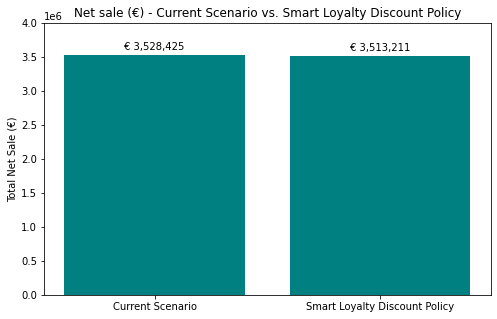

In [55]:
# Create bar chart
plt.figure(figsize=(8,5))
plt.bar(data_bar['metric'], data_bar['value'],color='teal')
plt.xticks(rotation=0)
plt.ylim(0,4000000)

# Plot the figure.
plt.title('Net sale (€) - Current Scenario vs. Smart Loyalty Discount Policy')
# plt.xlabel('Total Net Sale (€)')
plt.ylabel('Total Net Sale (€)')

for x,y in zip(data_bar['metric'], data_bar['value']):

    label = "€ {:,.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.show()